In [3]:
from typing import Annotated, Optional
from typing_extensions import TypedDict, Annotated
from operator import add

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.errors import InvalidUpdateError
from langgraph.graph.message import add_messages, AnyMessage

from langchain_core.messages import HumanMessage, AIMessage

from IPython.display import Image, display

This code defines a simple LangGraph that stores a single integer (`tally`). It runs one node, `bump`, which prints a message and increments the tally by 1. The graph flow is START → bump → END, and invoking it with `{"tally": 1}` returns `{"tally": 2}`.


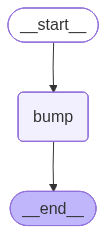

→ bump() ran
Overwrite demo: {'tally': 2}


In [4]:
class CounterState(TypedDict):
    tally: int

def bump(state: CounterState):
    print("→ bump() ran")
    return {"tally": state["tally"] + 1}

g_over = StateGraph(CounterState)
g_over.add_node("bump", bump)
g_over.add_edge(START, "bump")
g_over.add_edge("bump", END)
app_over = g_over.compile()

display(Image(app_over.get_graph().draw_mermaid_png()))

print("Overwrite demo:", app_over.invoke({"tally": 1}))  

This code defines a LangGraph where three nodes (`seed`, `branch_a`, `branch_b`) all increment the same `tally` key. After `seed` runs, the graph tries to run **both** `branch_a` and `branch_b` in parallel, and they each return an update to `tally`. Because LangGraph doesn’t know which `tally` to keep, this causes an `InvalidUpdateError` when `app_clash.invoke({"tally": 1})` runs, demonstrating a state key collision from parallel branches.


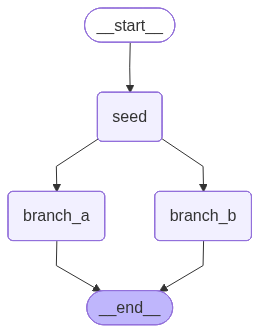

→ seed()
→ branch_a()
→ branch_b()
⚠️ Collision error (expected): At key 'tally': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


In [5]:
class ClashState(TypedDict):
    tally: int  

def seed(state: ClashState):
    print("→ seed()")
    return {"tally": state["tally"] + 1}

def branch_a(state: ClashState):
    print("→ branch_a()")
    return {"tally": state["tally"] + 1}

def branch_b(state: ClashState):
    print("→ branch_b()")
    return {"tally": state["tally"] + 1}

g_clash = StateGraph(ClashState)
g_clash.add_node("seed", seed)
g_clash.add_node("branch_a", branch_a)
g_clash.add_node("branch_b", branch_b)

g_clash.add_edge(START, "seed")
g_clash.add_edge("seed", "branch_a")
g_clash.add_edge("seed", "branch_b")
g_clash.add_edge("branch_a", END)
g_clash.add_edge("branch_b", END)

app_clash = g_clash.compile()

display(Image(app_clash.get_graph().draw_mermaid_png()))

try:
    app_clash.invoke({"tally": 1})
except InvalidUpdateError as e:
    print("⚠️ Collision error (expected):", e)

This code fixes the earlier collision by making `tally` a list with an `add` reducer. Each node (`seed`, `branch_a`, `branch_b`) appends the next number based on the last `tally` value. When `branch_a` and `branch_b` run in parallel, their list updates are merged instead of colliding, so `app_clash.invoke({"tally": [1]})` returns a combined history of increments (no `InvalidUpdateError` is raised; the `try/except` is just defensive).


In [ ]:
class ClashState(TypedDict):
    tally: Annotated[list[int], add]

def seed(state: ClashState):
    print("→ seed()")
    return {"tally": [state['tally'][-1] + 1]}

def branch_a(state: ClashState):
    print("→ branch_a()")
    return {"tally": [state['tally'][-1] + 1]}

def branch_b(state: ClashState):
    print("→ branch_b()")
    return {"tally": [state['tally'][-1] + 1]}

g_clash = StateGraph(ClashState)
g_clash.add_node("seed", seed)
g_clash.add_node("branch_a", branch_a)
g_clash.add_node("branch_b", branch_b)

g_clash.add_edge(START, "seed")
g_clash.add_edge("seed", "branch_a")
g_clash.add_edge("seed", "branch_b")
g_clash.add_edge("branch_a", END)
g_clash.add_edge("branch_b", END)

app_clash = g_clash.compile()

display(Image(app_clash.get_graph().draw_mermaid_png()))

try:
    print(app_clash.invoke({"tally": [1]}))
except InvalidUpdateError as e:
    print("⚠️ Collision error (expected):", e)


This code shows how to **merge parallel updates by summing**. The `tally` field is an `int` with an `add` reducer, so all `{"tally": 1}` updates get added together. The graph runs `start`, then both `path_a` and `path_b` in parallel. Starting from `{"tally": 0}`, the final result is `{"tally": 3}` (1 from each of the three nodes).


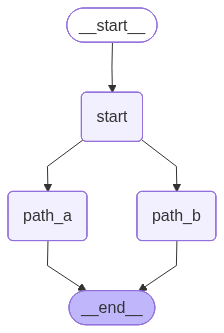

Merged tally: {'tally': 3}


In [6]:
class TallyState(TypedDict):
    tally: Annotated[int, add]   

def start(state: TallyState):
    return {"tally": 1}

def path_a(state: TallyState):
    return {"tally": 1}

def path_b(state: TallyState):
    return {"tally": 1}

g_sum = StateGraph(TallyState)
g_sum.add_node("start", start)
g_sum.add_node("path_a", path_a)
g_sum.add_node("path_b", path_b)

g_sum.add_edge(START, "start")
g_sum.add_edge("start", "path_a")
g_sum.add_edge("start", "path_b")
g_sum.add_edge("path_a", END)
g_sum.add_edge("path_b", END)

app_sum = g_sum.compile()
display(Image(app_sum.get_graph().draw_mermaid_png()))

print("Merged tally:", app_sum.invoke({"tally": 0}))   

This example shows a **bad initial value** for a reducer field. `tally` is an `int` with an `add` reducer, but the graph is invoked with `{"tally": None}`. Nodes `seed`, `a`, and `b` all return `{"tally": 1}`, so LangGraph tries to do `None + 1 + 1 + 1`, which raises a merge error (e.g. a `TypeError`). The `try/except` catches this and prints that `None + int` merging failed.


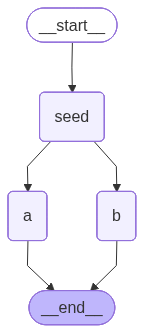

❌ None + int merge failed: TypeError - unsupported operand type(s) for +: 'int' and 'NoneType'


In [7]:
class TallyStateBad(TypedDict):
    tally: Annotated[int, add]

def seed_bad(state: TallyStateBad):
    return {"tally": 1}

def a_bad(state: TallyStateBad):
    return {"tally": 1}

def b_bad(state: TallyStateBad):
    return {"tally": 1}

g_bad = StateGraph(TallyStateBad)
g_bad.add_node("seed", seed_bad)
g_bad.add_node("a", a_bad)
g_bad.add_node("b", b_bad)
g_bad.add_edge(START, "seed")
g_bad.add_edge("seed", "a")
g_bad.add_edge("seed", "b")
g_bad.add_edge("a", END)
g_bad.add_edge("b", END)
app_bad = g_bad.compile()
display(Image(app_bad.get_graph().draw_mermaid_png()))

try:
    print(app_bad.invoke({"tally": None}))
except Exception as e:
    print("❌ None + int merge failed:", type(e).__name__, "-", e)

This version fixes the `None` problem by using a **custom reducer**. `tally` uses `reduce_sum_none_safe`, which treats `None` as `0` before adding. The graph is the same fan-out as before (`seed → a` and `seed → b`), each returning `{"tally": 1}`. Now invoking with `{"tally": None}` works: all updates merge cleanly and you get a summed `tally` (e.g. `3`) instead of a crash.


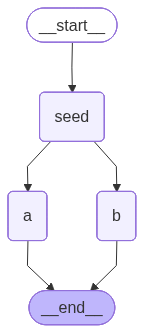

✅ None-safe merge: {'tally': 3}


In [8]:
def reduce_sum_none_safe(left: Optional[int], right: Optional[int]) -> int:
    """Treat None as 0, then sum."""
    return (left or 0) + (right or 0)

class TallyStateGood(TypedDict):
    tally: Annotated[int, reduce_sum_none_safe]

def seed_good(state: TallyStateGood):
    return {"tally": 1}

def a_good(state: TallyStateGood):
    return {"tally": 1}

def b_good(state: TallyStateGood):
    return {"tally": 1}

g_good = StateGraph(TallyStateGood)
g_good.add_node("seed", seed_good)
g_good.add_node("a", a_good)
g_good.add_node("b", b_good)
g_good.add_edge(START, "seed")
g_good.add_edge("seed", "a")
g_good.add_edge("seed", "b")
g_good.add_edge("a", END)
g_good.add_edge("b", END)
app_good = g_good.compile()
display(Image(app_good.get_graph().draw_mermaid_png()))

print("✅ None-safe merge:", app_good.invoke({"tally": None}))  

This example shows two graphs that behave the same way when updating chat history. Both graphs have a `messages` list field that uses the `add_messages` reducer to append new messages. Graph A relies on LangGraph’s built-in `MessagesState`, while Graph B defines an explicit `MyMsgState` with `messages: Annotated[list[AnyMessage], add_messages]`. The shared `assistant` node looks at the last `HumanMessage` in `state["messages"]` and returns a new `AIMessage` in a one-element list; the reducer appends that reply to the existing list. Given the same initial `messages` input, both graphs produce the same final message list.


In [9]:
class MyMsgState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]



def assistant(state):
    # reply echoes last human content uppercased
    last_human = next((m for m in reversed(state["messages"]) if isinstance(m, HumanMessage)), None)
    reply = f"ECHO: {last_human.content.upper()}" if last_human else "NO HUMAN"
    return {"messages": [AIMessage(content=reply)]}  # append via reducer


# Graph A: built-in MessagesState
g1 = StateGraph(MessagesState)
g1.add_node("assistant", assistant)
g1.add_edge(START, "assistant")
g1.add_edge("assistant", END)
graph_a = g1.compile()

# Graph B: explicit Annotated + add_messages
g2 = StateGraph(MyMsgState)
g2.add_node("assistant", assistant)
g2.add_edge(START, "assistant")
g2.add_edge("assistant", END)
graph_b = g2.compile()

This snippet runs both graphs with the same initial input (`{"messages": [HumanMessage("hello there")]}`). Each graph’s `assistant` node appends an uppercased echo reply. After invocation, the code extracts the message `content` from each graph’s output and compares the sequences. Both graphs produce same message lists, confirming that their update behavior is equivalent.


In [10]:
inp = {"messages": [HumanMessage(content="hello there")]}
out_a = graph_a.invoke(inp)
out_b = graph_b.invoke(inp)

seq_a = [getattr(m, "content", None) for m in out_a["messages"]]
seq_b = [getattr(m, "content", None) for m in out_b["messages"]]

print("A:", seq_a)
print("B:", seq_b)
print("Equivalent?", seq_a == seq_b)

A: ['hello there', 'ECHO: HELLO THERE']
B: ['hello there', 'ECHO: HELLO THERE']
Equivalent? True


This snippet checks that both graphs stay in sync over multiple turns. First, each graph is invoked with a single human message. Then a second human message (`"and another question"`) is appended to each graph’s output and both graphs are invoked again. The helper `contents()` just pulls `content` from each message list so you can compare Graph A and Graph B and verify they still produce matching histories across turns.


In [11]:
s1 = {"messages": [HumanMessage(content="hello there")]}
oA1 = graph_a.invoke(s1)
oB1 = graph_b.invoke(s1)

s2A = {"messages": oA1["messages"] + [HumanMessage(content="and another question")]}
s2B = {"messages": oB1["messages"] + [HumanMessage(content="and another question")]}
oA2 = graph_a.invoke(s2A)
oB2 = graph_b.invoke(s2B)

def contents(msgs): return [getattr(m, "content", None) for m in msgs]

This prints the message histories produced by both graphs after the first turn. Since each graph appends the same AI reply to the same initial human message, their `contents()` lists match. The final comparison confirms that Graph A and Graph B remain same after Turn 1.


In [12]:
print("Turn 1 A:", contents(oA1["messages"]))
print("Turn 1 B:", contents(oB1["messages"]))
print("Equal after Turn 1?", contents(oA1["messages"]) == contents(oB1["messages"]))

Turn 1 A: ['hello there', 'ECHO: HELLO THERE']
Turn 1 B: ['hello there', 'ECHO: HELLO THERE']
Equal after Turn 1? True


This prints both graphs’ message histories after the second turn. Each graph receives the same two human messages and generates the same appended AI reply, so their `contents()` sequences remain same. The comparison confirms both graphs stay fully equivalent across multiple turns.


In [13]:
print("\nTurn 2 A:", contents(oA2["messages"]))
print("Turn 2 B:", contents(oB2["messages"]))
print("Equal after Turn 2?", contents(oA2["messages"]) == contents(oB2["messages"]))


Turn 2 A: ['hello there', 'ECHO: HELLO THERE', 'and another question', 'ECHO: AND ANOTHER QUESTION']
Turn 2 B: ['hello there', 'ECHO: HELLO THERE', 'and another question', 'ECHO: AND ANOTHER QUESTION']
Equal after Turn 2? True
